# Mercari Interactive EDA + Topic Modelling
https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling

# Introduction
matplotlib을 이용한 Mercari 가격에 대한 탐색적 분석을 진행합니다.

bokeh와 plot.ly는 그림과 대시보드와 상호작용할 수 있는 좋은 시각화 도구입니다. 

이 경쟁은 Mercari라는 일본의 커뮤니티 기반 쇼핑앱에서 주최됐습니다. 주요 목적은 품목의 정보가 주어졌을 때, 판매자에게 정확한 가격을 예측해 판매자에게 제공해야합니다.

해당 커널은 2가지 파트로 이루어져 있습니다.

1. EDA
2. 텍스트 프로세싱

    2.1. 토크나이징과 tf-idf 알고리즘
    
    2.2. K-평균 군집
    
    2.3. LDA(잠재 디리클레 할당) / 토픽 모델링

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.size:    10.0')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 364 ('axes.titlesize:     large   # fontsize of the axes title')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 370 ('axes.labelsize:     medium  # fontsize of the x any y labels')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 469 ('xtick.labelsize:     medium  # fontsize of the tick labels')
Duplicate key in file WindowsPath('C:/ProgramData/Anaconda3/envs/tens_2g/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 489 ('ytick.labelsize:     medium  # fontsize of the tick labels')


In [2]:
train = pd.read_csv('./input/train.tsv', sep='\t')
test = pd.read_csv('./input/test.tsv', sep='\t')

In [3]:
# 데이터셋 크기 확인
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [4]:
# 데이터셋 타입 확인
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## Target Variable: Price
우리의 반응(타겟)변수는 판매자에게 제안할 `price`입니다. 모든 품목 가격의 중위값은 $267 이지만, 제일 비싼 가격은 $2,009입니다. 또한 분포가 매우 왼쪽으로 치우쳐있음을 알 수 있습니다. 

따라서 가격을 log 변환하여 정규근사시킵니다.(1을 더해 값이 0이되거나 음수가 나오는 것을 방지)

In [6]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [8]:
train['price_log'] = np.log(train['price']+1)

Text(0.5, 1.0, 'Log(Price) Distribution - Training Set')

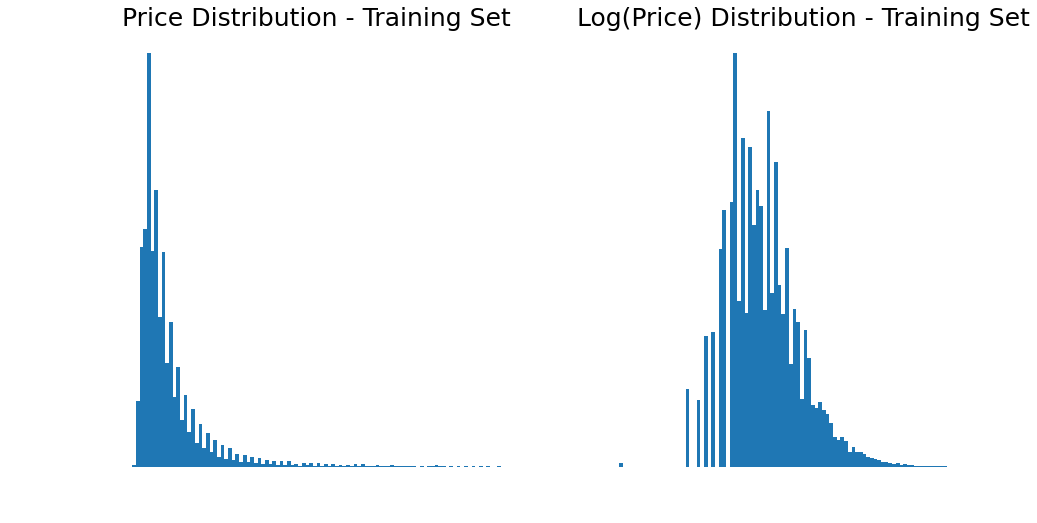

In [23]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
plt.subplot(1,2,1)
plt.hist(train['price'],bins=100, range=(0,250))
plt.xlabel('price+')
plt.ylabel('frequency')
plt.title('Price Distribution - Training Set')
plt.subplot(1,2,2)
plt.hist(train['price_log'], bins=100)
plt.xlabel('log(price+1)')
plt.ylabel('frequency')
plt.title('Log(Price) Distribution - Training Set')

(array([2.0000e+00, 2.0000e+00, 2.5000e+01, 1.1800e+02, 4.1800e+02,
        1.4000e+03, 3.5030e+03, 7.3090e+03, 1.2386e+04, 1.6530e+04,
        1.8209e+04, 1.6463e+04, 1.1633e+04, 6.9220e+03, 3.2960e+03,
        1.2750e+03, 3.8800e+02, 9.7000e+01, 2.1000e+01, 3.0000e+00]),
 array([-0.22226873,  0.27699582,  0.77626036,  1.27552491,  1.77478946,
         2.274054  ,  2.77331855,  3.2725831 ,  3.77184764,  4.27111219,
         4.77037674,  5.26964128,  5.76890583,  6.26817038,  6.76743492,
         7.26669947,  7.76596402,  8.26522857,  8.76449311,  9.26375766,
         9.76302221]),
 <BarContainer object of 20 artists>)

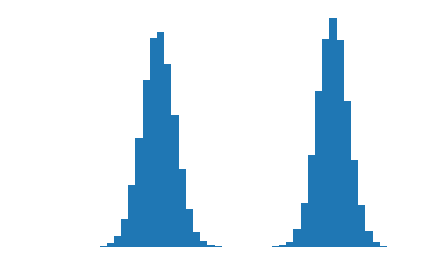

In [36]:
N_points = 100000
n_bins = 20

# Generate a normal distribution, center at x=0 and y=5
x = np.random.randn(N_points)
y = .4 * x + np.random.randn(100000) + 5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)

## Shipping
배송비 부담은 품목의 절반 이상의 판매자(55%)가 부담합니다. 또한 배송비를 지불해야 하는 사용자가 지부하는 평균 가격은 추가 배송비가 필요하지 않은 가격보다 낮습니다. 이는 판매자들이 추가 배송비를 보상하기 위해 더 낮은 가격을 책정한다는 우리의 인식과 일치합니다.

In [28]:
train['shipping'].value_counts() / len(train['shipping'])

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [29]:
prc_shipBySeller = train.loc[train.shipping == 1, 'price']
prc_shipByBuyer = train.loc[train.shipping == 0, 'price']

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
        label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=1.0, bins=50,
        label='Price when Seller pays Shipping')